# Prediction using can yo

Credits to https://www.kaggle.com/code/tarundirector/histology-eda-spotnet-visual-spatial-dl . Kudos for the amazing notebook!



In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
    -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.6 MB/s eta 0:00:00:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 89.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:0000:01


In [3]:
nb_type = "Submission"

In [4]:
# --- Core Python Libraries ---
import os
import math

# --- Data Processing ---
import numpy as np
import pandas as pd
import h5py

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle

# --- Deep Learning: PyTorch & TorchVision ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# --- Metrics ---
from scipy.stats import spearmanr

In [ ]:
from torch_geometric.nn import GATConv
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
import torch.nn.functional as F

class SpotGNN(torch.nn.Module):
    def __init__(self, in_dim=640, hidden_dim=256, out_dim=35):  # 512+128 if using ResNet34
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(4 * hidden_dim, out_dim, heads=1)

    def forward(self, x, edge_index):
        x = F.relu(self.gat1(x, edge_index))
        return self.gat2(x, edge_index)


def extract_spotnet_features(model, features):
    model.eval()
    all_feats = []
    with torch.no_grad():
        for img5, coord2 in features:
            img5 = img5.unsqueeze(0).to(DEVICE)
            coord2 = coord2.unsqueeze(0).to(DEVICE)
            f_img = model.cnn(img5)
            f_coord = model.coord_mlp(model.coord_ff(coord2))
            feat = torch.cat([f_img, f_coord], dim=1).squeeze(0).cpu()
            all_feats.append(feat)
    return torch.stack(all_feats)  # [N, feature_dim]


def build_features_and_graph(df_slide, images, transform, k=6):
    features = []
    labels = []
    coords = []
    slide = df_slide["slide"].iloc[0]
    img = images[slide]
    h, w, _ = img.shape

    for i, row in df_slide.iterrows():
        x, y = row["x"], row["y"]
        x_norm, y_norm = row["x_norm"], row["y_norm"]
        lbl = torch.tensor(row["label"], dtype=torch.float32)

        half = PATCH_SIZE // 2
        y0, y1 = max(0,y-half), min(h,y+half)
        x0, x1 = max(0,x-half), min(w,x+half)
        patch = img[y0:y1, x0:x1]
        pad_y = (max(0,half-y), max(0,(y+half)-h))
        pad_x = (max(0,half-x), max(0,(x+half)-w))
        patch = np.pad(patch, (pad_y, pad_x, (0,0)), mode='constant', constant_values=0)
        img_t = transform(patch)

        x_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), x_norm)
        y_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), y_norm)
        img5 = torch.cat([img_t, x_map, y_map], dim=0)

        coord2 = torch.tensor([x_norm, y_norm], dtype=torch.float32)

        features.append((img5, coord2))
        labels.append(lbl)
        coords.append([x_norm, y_norm])

    coords = np.array(coords)
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    edge_index = nbrs.kneighbors_graph(coords).tocoo()
    edge_index = torch.tensor(np.vstack([edge_index.row, edge_index.col]), dtype=torch.long)

    return features, torch.stack(labels), edge_index


def train_spotgnn_for_fold(fold, df_fold, images, transform, model_path, save_path="gnn_fold{}.pt", epochs=20, k=6):
    print(f"\n🔁 Training SpotGNN for fold {fold}")
    
    # Load SpotNet
    spotnet = SpotNet(num_types=NUM_CELL_TYPES).to(DEVICE)
    spotnet.load_state_dict(torch.load(model_path.format(fold)))
    spotnet.eval()

    # Build features and graph
    features, labels, edge_index = build_features_and_graph(df_fold, images, transform, k=k)
    x_all = extract_spotnet_features(spotnet, features).to(DEVICE)
    labels = labels.to(DEVICE)
    edge_index = edge_index.to(DEVICE)

    # Train GNN
    gnn = SpotGNN(in_dim=x_all.shape[1], out_dim=NUM_CELL_TYPES).to(DEVICE)
    optimizer = torch.optim.Adam(gnn.parameters(), lr=1e-3)

    for epoch in range(1, epochs + 1):
        gnn.train()
        preds = gnn(x_all, edge_index)
        loss = F.mse_loss(preds, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        print(f"[Fold {fold} | Epoch {epoch}] GNN Loss: {loss.item():.4f}")

    # Save GNN
    torch.save(gnn.state_dict(), save_path.format(fold))
    print(f"✅ Saved GNN model for fold {fold} to {save_path.format(fold)}")


In [ ]:
def forward_graph_spotnet(model, gnn, features, edge_index):
    """
    Apply SpotNet to extract features, then GNN for refinement.
    """
    model.eval(); gnn.eval()
    with torch.no_grad():
        xs = []
        for img5, coord2 in features:
            img5 = img5.unsqueeze(0).to(DEVICE)
            coord2 = coord2.unsqueeze(0).to(DEVICE)
            feat = model.cnn(img5)
            coord_feat = model.coord_mlp(model.coord_ff(coord2))
            x = torch.cat([feat, coord_feat], dim=1)
            xs.append(x.squeeze(0).cpu())
        x_all = torch.stack(xs)
        preds = gnn(x_all.to(DEVICE), edge_index.to(DEVICE))
    return preds.cpu()


In [ ]:
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def build_slide_graph(df_slide, images, transform, k=6):
    """
    Build a graph of spots within a single slide.
    Each node has img5, coord2, and label.
    """
    features = []
    labels = []
    coords = []
    
    slide = df_slide["slide"].iloc[0]
    img = images[slide]
    h, w, _ = img.shape

    for i, row in df_slide.iterrows():
        x, y = row["x"], row["y"]
        x_norm, y_norm = row["x_norm"], row["y_norm"]
        lbl = torch.tensor(row["label"], dtype=torch.float32)

        # extract patch
        half = PATCH_SIZE // 2
        y0, y1 = max(0,y-half), min(h,y+half)
        x0, x1 = max(0,x-half), min(w,x+half)
        patch = img[y0:y1, x0:x1]
        pad_y = (max(0,half-y), max(0,(y+half)-h))
        pad_x = (max(0,half-x), max(0,(x+half)-w))
        patch = np.pad(patch, (pad_y, pad_x, (0,0)), mode='constant', constant_values=0)
        img_t = transform(patch)

        x_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), x_norm)
        y_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), y_norm)
        img5 = torch.cat([img_t, x_map, y_map], dim=0)

        coord2 = torch.tensor([x_norm, y_norm], dtype=torch.float32)

        features.append((img5, coord2))
        labels.append(lbl)
        coords.append([x_norm, y_norm])

    coords = np.array(coords)
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    edge_index = nbrs.kneighbors_graph(coords).tocoo()
    edge_index = torch.tensor(np.vstack([edge_index.row, edge_index.col]), dtype=torch.long)

    return features, labels, edge_index


In [ ]:
# Trnasform images and spots into a dataframe. Used for implemeting cross-validation more easily
def build_spot_dataframe(images, spots, shifts):
    rows = []
    for slide in images:
        img = images[slide]
        h, w, _ = img.shape
        dx, dy = shifts.get(slide, (0, 0))
        for i, spot in enumerate(spots[slide]):
            x, y = spot["x"] + dx, spot["y"] + dy
            x_norm, y_norm = x / w, y / h
            label = [spot[f"C{j}"] for j in range(1, NUM_CELL_TYPES + 1)]
            rows.append({
                "slide": slide,
                "x": int(x),
                "y": int(y),
                "x_norm": x_norm,
                "y_norm": y_norm,
                "label": label
            })
    return pd.DataFrame(rows)



In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os, h5py, math
import numpy as np, pandas as pd
import torch
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# --- 1) Load data dicts ---
file_path = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"
with h5py.File(file_path, "r") as f:
    train_images = {k: np.array(v) for k,v in f["images/Train"].items()}
    train_spots  = {k: np.array(v) for k,v in f["spots/Train"].items()}
    test_images  = {k: np.array(v) for k,v in f["images/Test"].items()}
    test_spots   = {k: np.array(v) for k,v in f["spots/Test"].items()}

# --- 2) Slide-specific pixel shifts (as before) ---
shifts = {
    "S_1":(-65,-70), "S_2":(-65,-70),
    "S_3":(-15,0),   "S_4":(0,0),
    "S_5":(0,0),     "S_6":(-30,0),
    # S_7: test → defaults to (0,0)
}

# --- 3) Hyperparams & Transforms ---
PATCH_SIZE     = 384
BATCH_SIZE     = 16
LR             = 1e-4
EPOCHS         = 20
NUM_CELL_TYPES = 35
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomAffine(10, scale=(0.9,1.1)),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# --- 4) Dataset: returns (img5chan, coord2, label) or (img5chan, coord2, idx) ---
class HistologyDatasetFromDF(Dataset):
    def __init__(self, df, images, transform):
        self.df = df.reset_index(drop=True)
        self.images = images
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slide = row["slide"]
        x, y = row["x"], row["y"]
        x_norm, y_norm = row["x_norm"], row["y_norm"]
        label = row["label"]

        img = self.images[slide]
        h, w, _ = img.shape
        half = PATCH_SIZE // 2

        # crop with padding
        y0, y1 = max(0, y-half), min(h, y+half)
        x0, x1 = max(0, x-half), min(w, x+half)
        patch = img[y0:y1, x0:x1]
        pad_y = (max(0, half - y), max(0, (y + half) - h))
        pad_x = (max(0, half - x), max(0, (x + half) - w))
        patch = np.pad(patch, (pad_y, pad_x, (0, 0)), mode='constant', constant_values=0)
        img_t = self.transform(patch)

        x_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), x_norm)
        y_map = torch.full((1, PATCH_SIZE, PATCH_SIZE), y_norm)
        img5 = torch.cat([img_t, x_map, y_map], dim=0)

        coord2 = torch.tensor([x_norm, y_norm], dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return img5, coord2, label


# --- 5) Fourier MLP on 2-D coords ---
class FourierFeature(nn.Module):
    def __init__(self, in_dim=2, mapping_size=64, scale=10.0):
        super().__init__()
        B = torch.randn(mapping_size, in_dim) * scale
        self.register_buffer("B", B)

    def forward(self, x):
        x_proj = 2*math.pi * x @ self.B.t()        # [B,64]
        return torch.cat([x_proj.sin(), x_proj.cos()], dim=-1)  # [B,128]

# --- 6) Hybrid CoordConv + CoordMLP SpotNet ---
class SpotNet(nn.Module):
    def __init__(self, num_types=35, backbone="resnet34"):
        super().__init__()
        # --- Image tower with CoordConv(5→64) ---
        if backbone=="resnet34":
            cnn = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        else:
            cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        old1 = cnn.conv1
        new1 = nn.Conv2d(5, old1.out_channels,
                         kernel_size=old1.kernel_size,
                         stride=old1.stride,
                         padding=old1.padding,
                         bias=old1.bias is not None)
        with torch.no_grad():
            new1.weight[:,:3] = old1.weight  # copy RGB
            new1.weight[:,3:] = old1.weight[:,:2].mean(dim=1,keepdim=True)*0.0
        cnn.conv1 = new1
        dim = cnn.fc.in_features
        cnn.fc = nn.Identity()
        self.cnn = cnn

        # --- Coord MLP tower ---
        self.coord_ff  = FourierFeature(in_dim=2, mapping_size=64, scale=10.0)
        self.coord_mlp = nn.Sequential(
            nn.Linear(128,256), nn.ReLU(),
            nn.Linear(256,128), nn.ReLU()
        )

        # --- Fusion head ---
        self.head = nn.Sequential(
            nn.Linear(dim + 128, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256),       nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_types)
        )

    def forward(self, img5, coord2):
        f = self.cnn(img5)              # [B, dim]
        h = self.coord_ff(coord2)       # [B,128]
        h = self.coord_mlp(h)           # [B,128]
        x = torch.cat([f, h], dim=1)    # [B, dim+128]
        return self.head(x)             # [B,35]

# --- 7) Loss & validation ---
def spearman_loss(pred, target):
    rho=[]
    p_np=pred.detach().cpu().numpy()
    t_np=target.detach().cpu().numpy()
    for p,t in zip(p_np,t_np):
        r = spearmanr(p,t)[0]
        if not np.isnan(r): rho.append(r)
    return 1 - np.mean(rho)

def valid_loop(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for img5, coord2, y in loader:
            img5, coord2 = img5.to(DEVICE), coord2.to(DEVICE)
            preds.append(model(img5, coord2).cpu())
            trues.append(y)
    preds = torch.cat(preds); trues = torch.cat(trues)
    return spearman_loss(preds, trues)

In [ ]:
from sklearn.model_selection import train_test_split

#df_spots = build_spot_dataframe(train_images, train_spots, shifts)
#df_train, df_val = train_test_split(df_spots, test_size=0.15, random_state=42, stratify=df_spots["slide"])


🔁 Fold 1


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]


🚀 Starting training for fold 1
[Fold 1 | Epoch 1] Train-Loss: 1.0092  Val-Spearman: 0.4438
✅ Saved best model for fold 1 (Spearman=0.4438)
[Fold 1 | Epoch 2] Train-Loss: 0.7931  Val-Spearman: 0.4894
✅ Saved best model for fold 1 (Spearman=0.4894)
[Fold 1 | Epoch 3] Train-Loss: 0.7079  Val-Spearman: 0.5429
✅ Saved best model for fold 1 (Spearman=0.5429)
[Fold 1 | Epoch 4] Train-Loss: 0.6065  Val-Spearman: 0.5709
✅ Saved best model for fold 1 (Spearman=0.5709)
[Fold 1 | Epoch 5] Train-Loss: 0.5292  Val-Spearman: 0.5629
[Fold 1 | Epoch 6] Train-Loss: 0.4664  Val-Spearman: 0.6116
✅ Saved best model for fold 1 (Spearman=0.6116)
[Fold 1 | Epoch 7] Train-Loss: 0.4237  Val-Spearman: 0.6259
✅ Saved best model for fold 1 (Spearman=0.6259)
[Fold 1 | Epoch 8] Train-Loss: 0.3934  Val-Spearman: 0.6551
✅ Saved best model for fold 1 (Spearman=0.6551)
[Fold 1 | Epoch 9] Train-Loss: 0.3594  Val-Spearman: 0.6288
[Fold 1 | Epoch 10] Train-Loss: 0.3263  Val-Spearman: 0.6285
[Fold 1 | Epoch 11] Train-Loss: 

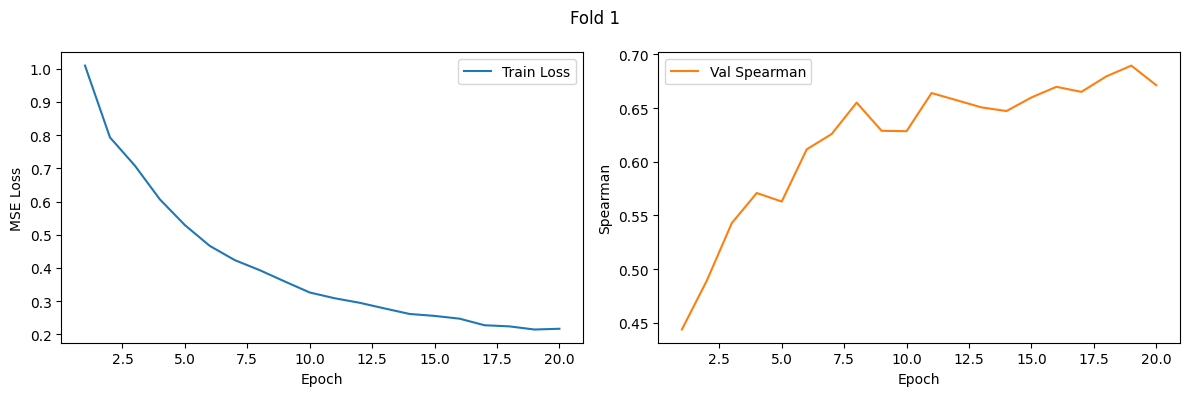


✅ Fold 1 complete. Best Val Spearman = 0.6896

🔁 Fold 2
🚀 Starting training for fold 2
[Fold 2 | Epoch 1] Train-Loss: 1.0125  Val-Spearman: 0.5136
✅ Saved best model for fold 2 (Spearman=0.5136)
[Fold 2 | Epoch 2] Train-Loss: 0.7682  Val-Spearman: 0.4459
[Fold 2 | Epoch 3] Train-Loss: 0.6855  Val-Spearman: 0.5695
✅ Saved best model for fold 2 (Spearman=0.5695)
[Fold 2 | Epoch 4] Train-Loss: 0.5547  Val-Spearman: 0.5946
✅ Saved best model for fold 2 (Spearman=0.5946)
[Fold 2 | Epoch 5] Train-Loss: 0.4771  Val-Spearman: 0.6141
✅ Saved best model for fold 2 (Spearman=0.6141)
[Fold 2 | Epoch 6] Train-Loss: 0.4502  Val-Spearman: 0.6377
✅ Saved best model for fold 2 (Spearman=0.6377)
[Fold 2 | Epoch 7] Train-Loss: 0.3919  Val-Spearman: 0.6205
[Fold 2 | Epoch 8] Train-Loss: 0.3664  Val-Spearman: 0.6435
✅ Saved best model for fold 2 (Spearman=0.6435)
[Fold 2 | Epoch 9] Train-Loss: 0.3313  Val-Spearman: 0.6583
✅ Saved best model for fold 2 (Spearman=0.6583)
[Fold 2 | Epoch 10] Train-Loss: 0.31

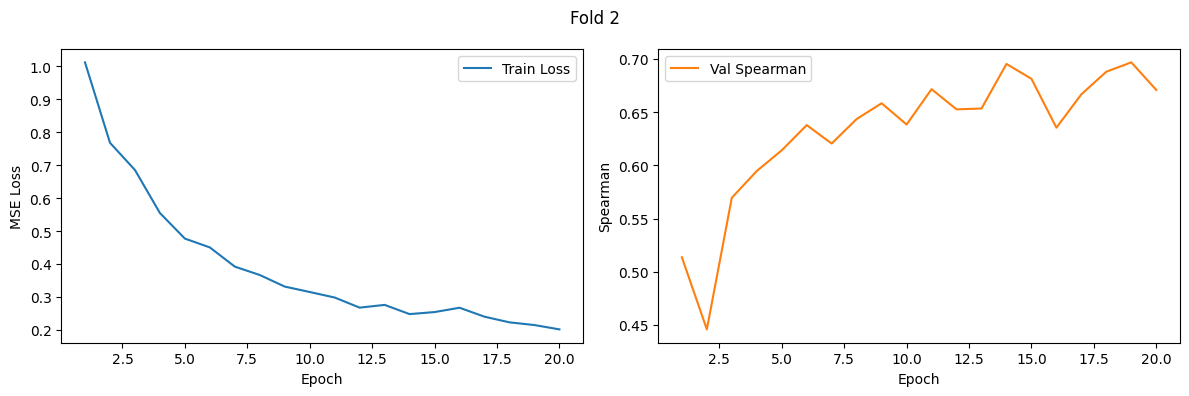


✅ Fold 2 complete. Best Val Spearman = 0.6967

🔁 Fold 3
🚀 Starting training for fold 3


In [ ]:
nb_type = "Train"
from sklearn.model_selection import StratifiedKFold

if nb_type == "Train":
    # Step 1: Build spot-level DataFrame
    df_spots = build_spot_dataframe(train_images, train_spots, shifts)

    # Step 2: Initialize k-fold splitter
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_spots, df_spots["slide"])):
        print(f"\n🔁 Fold {fold + 1}")
        df_train = df_spots.iloc[train_idx].reset_index(drop=True)
        df_val   = df_spots.iloc[val_idx].reset_index(drop=True)

        ds_tr = HistologyDatasetFromDF(df_train, train_images, train_tfm)
        ds_va = HistologyDatasetFromDF(df_val, train_images, eval_tfm)

        loader_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
        loader_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        model     = SpotNet(num_types=NUM_CELL_TYPES).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LR)
        criterion = nn.MSELoss()

        history, best_spear = {"train_loss":[], "val_spearman":[]}, -1
        print("🚀 Starting training for fold", fold + 1)
        for epoch in range(1, EPOCHS+1):
            # train epoch
            model.train()
            tloss = 0
            for img5, coord2, y in loader_tr:
                img5, coord2, y = img5.to(DEVICE), coord2.to(DEVICE), y.to(DEVICE)
                p = model(img5, coord2)
                l = criterion(p, y)
                optimizer.zero_grad(); l.backward(); optimizer.step()
                tloss += l.item()
            tloss /= len(loader_tr)

            # validate
            vspear = 1 - valid_loop(model, loader_va)
            history["train_loss"].append(tloss)
            history["val_spearman"].append(vspear)
            print(f"[Fold {fold+1} | Epoch {epoch}] Train-Loss: {tloss:.4f}  Val-Spearman: {vspear:.4f}")
            if vspear > best_spear:
                best_spear = vspear
                torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
                print(f"✅ Saved best model for fold {fold+1} (Spearman={best_spear:.4f})")

        # plot
        eps = list(range(1,EPOCHS+1))
        plt.figure(figsize=(12,4))
        plt.suptitle(f"Fold {fold+1}")
        plt.subplot(1,2,1)
        plt.plot(eps, history["train_loss"], label="Train Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        plt.subplot(1,2,2)
        plt.plot(eps, history["val_spearman"], label="Val Spearman", color="C1")
        plt.xlabel("Epoch"); plt.ylabel("Spearman"); plt.legend()
        plt.tight_layout(); plt.show()

        print(f"\n✅ Fold {fold+1} complete. Best Val Spearman = {best_spear:.4f}")


In [ ]:
# --- 10) Graph Refinement after SpotNet Training ---
use_gnn = True  # Set to False to skip this block

if use_gnn:
    for fold in range(1, 6):
        # Load validation set DataFrame for this fold
        df_val = ...  # You need to store or reconstruct this from earlier folds

        train_spotgnn_for_fold(
            fold=fold,
            df_fold=df_val,
            images=train_images,
            transform=eval_tfm,
            model_path="best_model_fold{}.pt",
            save_path="gnn_model_fold{}.pt",
            epochs=20
        )


In [ ]:
# --- 11) Submission block (SpotNet + GNN ensemble) ---
if nb_type == "Submission":
    ds_ts = HistologyDataset(test_images, test_spots, shifts,
                              ["S_7"], eval_tfm, mode="Submission")
    loader_ts = DataLoader(ds_ts, batch_size=1, shuffle=False, num_workers=2)

    # Load SpotNet + GNN models
    spotnets = []
    gnns = []
    for k in range(1, 6):
        # SpotNet
        sn = SpotNet(num_types=NUM_CELL_TYPES).to(DEVICE)
        sn.load_state_dict(torch.load(f"best_model_fold{k}.pt", map_location=DEVICE))
        sn.eval()
        spotnets.append(sn)

        # GNN
        gnn = SpotGNN(in_dim=640).to(DEVICE)  # 512+128 for ResNet34
        gnn.load_state_dict(torch.load(f"gnn_model_fold{k}.pt", map_location=DEVICE))
        gnn.eval()
        gnns.append(gnn)

    # Predict
    subs = []
    with torch.no_grad():
        for img5, coord2, idxs in loader_ts:
            img5, coord2 = img5.to(DEVICE), coord2.to(DEVICE)

            fold_preds = []
            for k in range(5):
                # Feature extraction from SpotNet
                f_img = spotnets[k].cnn(img5)
                f_coord = spotnets[k].coord_mlp(spotnets[k].coord_ff(coord2))
                feat = torch.cat([f_img, f_coord], dim=1)  # [1, 640]

                # GNN (acting like a 1-node graph)
                pred = gnns[k](feat, edge_index=torch.tensor([[0], [0]], device=DEVICE))  # dummy edge_index
                fold_preds.append(pred.squeeze(0).cpu())

            # Ensemble average
            final_pred = torch.stack(fold_preds).mean(dim=0).numpy()
            subs.append([idxs.item()] + final_pred.tolist())

    # Write submission file
    cols = ["ID"] + [f"C{j}" for j in range(1, NUM_CELL_TYPES + 1)]
    sub_df = pd.DataFrame(subs, columns=cols)
    sub_df.sort_values("ID", inplace=True)
    sub_df.to_csv("submission.csv", index=False)
    print("✅ submission.csv written:", sub_df.shape)
